<a href="https://colab.research.google.com/github/pharringtonp19/mecon/blob/main/notebooks/practice_final/RTC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture 
!pip install jaxopt 

In [2]:
#@title **Imports** { display-mode: "form" }
import jax 
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp 
import jaxopt 
from functools import partial 
from dataclasses import dataclass
from typing import Optional
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:

def inverse(f):

  def inverse_fn(y):
    
    def closure(x,y):
      return (f(x)-y)**2

    solver = jaxopt.GradientDescent(fun=closure, maxiter=2000)
    res = solver.run(jnp.ones(shape=()), y)
    return res.params

  return inverse_fn

In [4]:
#@title **Probability of Paying** { display-mode: "form" }
def prob_pay(renter_type, amt): 
  score = jax.nn.sigmoid(2.*(renter_type-0.5)) + (2000-amt)/4000 
  annual_rate = jnp.minimum(score, 1.)
  monthly_rate = annual_rate**(1/12)
  return monthly_rate

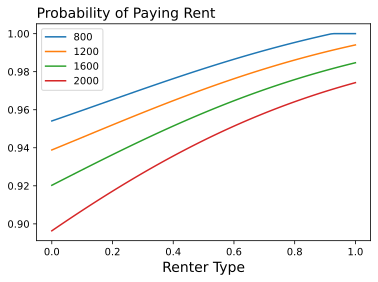

In [5]:
#@title **Plot Probability of Paying** { display-mode: "form" }
ts = jnp.linspace(0., 1., 100) # Vector of renter types 
amounts = [800, 1200, 1600, 2000]

for a in amounts:                     # Loop over amounts 
  f = partial(prob_pay, amt=a)        # Partially apply function
  f_vec = jax.vmap(f)                 # Vectorize function 
  ps = f_vec(ts)                      # Probability of paying amount 
  plt.plot(ts, ps, label=a)
plt.title('Probability of Paying Rent', loc='left', size=14)
plt.xlabel('Renter Type', size=14)
plt.legend()
plt.show()

In [6]:
#@title **Max Security Deposit** { display-mode: "form" }
def max_security_deposit(renter_type):
  return 1200.0 + 2000.0*renter_type 

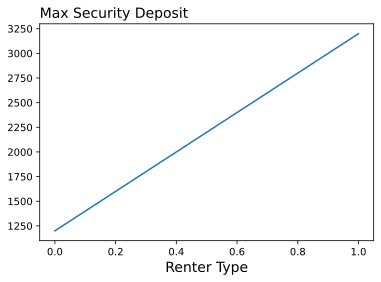

In [7]:
#@title **Plot Max Security Deposit** { display-mode: "form" }

rs = jnp.linspace(0, 1, 100)
max_deposit = max_security_deposit(rs)
plt.plot(rs, max_deposit)
plt.title('Max Security Deposit', loc='left', size=14)
plt.xlabel('Renter Type', size=14)
plt.show()

In [8]:
from jax.tree_util import register_pytree_node_class, tree_flatten, tree_unflatten

@dataclass 
@register_pytree_node_class
class State: 
  rtc: bool  
  renter_type: float    
  landlord_income: float 

  def tree_flatten(self):
    children = (self.rtc, self.renter_type, self.landlord_income)
    aux_data = None 
    return (children, aux_data)
  
  @classmethod 
  def tree_unflatten(cls, aux_data, children):
    return cls(*children)
  
@dataclass 
@register_pytree_node_class
class Choice_Variables: 
  security_deposit : float 
  monthly_rate : float 

  def tree_flatten(self):
    children = (self.security_deposit, self.monthly_rate)
    aux_data = None 
    return (children, aux_data)
  
  @classmethod 
  def tree_unflatten(cls, aux_data, children):
    return cls(*children)  

In [9]:
def update_occupied(state, cv, key):
  p = prob_pay(state.renter_type, cv.monthly_rate)
  paid_rent = jax.random.bernoulli(key, p)
  change_income = jnp.where(paid_rent, cv.monthly_rate, -(1 + state.rtc)*cv.monthly_rate)
  renter_type = jnp.where(paid_rent, state.renter_type, -1.)
  return State(state.rtc, renter_type, state.landlord_income + change_income)

In [10]:
def update_unoccupied(state, cv, key):
  renter_type = jax.random.uniform(key)
  rental_indicator = (max_security_deposit(renter_type) > cv.security_deposit)
  return State(state.rtc, jnp.where(rental_indicator, renter_type, -1.), state.landlord_income + jnp.where(rental_indicator, cv.security_deposit, 0.0))

In [11]:
def update(carry, key):
  state, cv = carry 
  new_state = jax.lax.cond(state.renter_type == -1.0 , update_unoccupied, update_occupied, state, cv, key)
  return (new_state, cv), state.landlord_income

In [12]:
def income_path(state, cv, key):
  (end_state, cv), income_path = jax.lax.scan(update, (state, cv), xs=jax.random.split(key, 12))
  return end_state.landlord_income

In [13]:
def policy_value(u, rtc, security_deposit, monthly_rate, key):
  state = State(rtc=True, renter_type=-1.0, landlord_income=0.0)
  cv = Choice_Variables(security_deposit, monthly_rate)
  incomes = jax.vmap(income_path, in_axes=(None, None, 0))(state, cv, jax.random.split(key, 100))
  return inverse(u)(jnp.mean(jax.vmap(u)(incomes)))

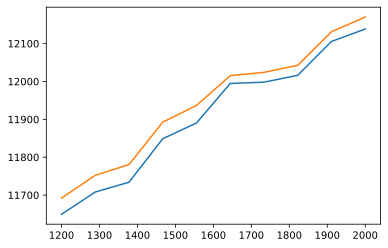

In [14]:
for a in [0.5, 1.0]:
  results = [] 
  for i in jnp.linspace(1200, 2000, 10):
    v = policy_value(lambda x: x**a, False, i, 1000.0, jax.random.PRNGKey(0))
    results.append(v)
  plt.plot(jnp.linspace(1200, 2000, 10), results)
plt.show() 
